# Spark + AI Summit 2020
## Bring Satellite & Drone Imagery into Your Data Science Workflows

**Jason T Brown**, Senior Data Scientist at [Astraea, Inc](https://astraea.earth/)

### Purpose of this notebook

Facilitate exploratory data analysis of this [Kaggle California wildfire dataset](https://www.kaggle.com/ananthu017/california-wildfire-incidents-20132020) and integration of land surface temperature data from [MODIS satellite mission](https://lpdaac.usgs.gov/products/mod11a1v006/).

This is a demo given in [the talk](https://databricks.com/session_na20/bring-satellite-and-drone-imagery-into-your-data-science-workflows) "Bring Satellite & Drone Imagery into Your Data Science Workflows" Friday June 26 at Spark+AI Summit.

### Running this notebook

You can sign up for a free trial of Astraea EarthAI Notebook which provides a fully managed JupyerLab notebook environment with RasterFrames and other dependencies already installed and configured. Visit our [products page](https://astraea.earth/platform/#notebook) to get your free trial started! 🎉

You can also find other procedures for [getting started here](https://rasterframes.io/getting-started.html).
 

In [1]:
import pandas
import geopandas
import numpy

import shapely.geometry
import pyrasterframes
from pyrasterframes.rasterfunctions import *
from pyrasterframes.utils import create_rf_spark_session
import pyrasterframes.rf_ipython
import pyspark.sql.functions as F

In [2]:
spark = create_rf_spark_session()

In the EarthAI Notebook environment, you can access the Spark UI from the `Spark` menu item.

### Define functions to handle geometry objects

These will create geometry objects for describing the fires. The first function `clean_lon_lat_cali` does some checks and creates a point geometry based on the two numeric longitude and latitude columns. There is no defined polygon describing the region affected by the fire, but there is an area of acres burned. The function `point_acres_to_poly` will create a roughly circular polygon around the point, of the same area.

In [3]:
from pyspark.sql.functions import udf
import geomesa_pyspark 
from geomesa_pyspark.types import PointUDT, PolygonUDT

# @udf(PointUDT())
def clean_lon_lat_cali(lon: float, lat: float) -> shapely.geometry.Point:
    """ Check the following 
         - both `lon` and `lat` arguments are non null
         - longitudes must range between -125 and -113; 
         - latitudes must range 32, 42
        For simplicity in any of these cases return an empty Point
        Else give a Point with the given `lon` and `lat`
    """
    import math
    import shapely.geometry
    if not math.isnan(lon) and (-125.0 < lon < -113) and \
        not math.isnan(lat) and (32.0 < lat < 42.0):
        return shapely.geometry.Point(lon, lat)
    else:
        return shapely.geometry.Point()
    
# @udf(PolygonUDT())
def point_acres_to_poly(point: shapely.geometry.Point, acres: float) -> shapely.geometry.Polygon:
    """
    Compute appox radius in arc 
    If acres is null or 0, return nominal 100 acre fire area
    Double the radius for an approx circular polygon containing the fire, or much of it
    """
    import math
    if math.isnan(acres) or acres <= 0.0:
        acres = 100
    area_approx_km2 = acres / 247 
    area_approx_arc = area_approx_km2 / 111.1 / 111.1
    radius_arc = math.sqrt(area_approx_arc / math.pi)
    return point.buffer(radius_arc)


### Get the wildfire dataset

If you have not yet configured the `kaggle` cli, see the instructions [here](https://github.com/Kaggle/kaggle-api#api-credentials).

In [4]:
!pip install --user kaggle

In [5]:
%%bash
if [ ! -f California_Fire_Incidents.csv ]
then
    /home/jovyan/.local/bin/kaggle datasets download \
            -d ananthu017/california-wildfire-incidents-20132020
    unzip california-wildfire-incidents-20132020.zip
fi

#### Read the data and create DF

For brevity and simplicitiy use the Pandas CSV reader then create a spark DataFrame with minimal tweaking.

Note the `drop_duplicates` is because the original file repeats records for different counties.

In [6]:
cal_fire_df = pandas.read_csv('California_Fire_Incidents.csv') \
                    .drop_duplicates('UniqueId', keep='first')
len(cal_fire_df)

1609

In [7]:
cal_fire_df.columns

Index(['AcresBurned', 'Active', 'AdminUnit', 'AirTankers', 'ArchiveYear',
       'CalFireIncident', 'CanonicalUrl', 'ConditionStatement',
       'ControlStatement', 'Counties', 'CountyIds', 'CrewsInvolved', 'Dozers',
       'Engines', 'Extinguished', 'Fatalities', 'Featured', 'Final',
       'FuelType', 'Helicopters', 'Injuries', 'Latitude', 'Location',
       'Longitude', 'MajorIncident', 'Name', 'PercentContained',
       'PersonnelInvolved', 'Public', 'SearchDescription', 'SearchKeywords',
       'Started', 'Status', 'StructuresDamaged', 'StructuresDestroyed',
       'StructuresEvacuated', 'StructuresThreatened', 'UniqueId', 'Updated',
       'WaterTenders'],
      dtype='object')

Clean up some of the NA handling so we can create a Spark DataFrame from this later. This is because in pandas 0.25 missing values are NaN, which are interpreted as float, even in string type columns.

In [8]:
for c in cal_fire_df.columns:
    s = cal_fire_df[c]
    if s.dtype == numpy.dtype('O'):
        #usually string with a double null
        cal_fire_df[c] = s.fillna('')

Next, we process the coordinates into point and polygon objects. We do this in Pandas dataframe, but can also do it in the Spark DataFrame, using the same functions as UDFs. We do it in the Pandas DataFrame, in order to use the python side geometry object in our search for satellite data.

In [9]:
cal_fire_df['geom'] = cal_fire_df.apply(
    lambda r: 
    point_acres_to_poly(clean_lon_lat_cali(r.Longitude, r.Latitude), r.AcresBurned), 
    axis=1)

Next clean up some of the date fields. This is also important because we are going to use it to search for satellite images.

In [10]:
from dateutil.parser import isoparse
cal_fire_df['start_date'] = cal_fire_df.Started.apply(
    lambda d: isoparse(d) if d > '2013' else None
)
cal_fire_df['extinguish_date'] = cal_fire_df.Extinguished.apply(
    lambda d: isoparse(d) if d > '2013' else None
)
cal_fire_df = cal_fire_df[~(cal_fire_df.extinguish_date < cal_fire_df.start_date)]

In [11]:
len(cal_fire_df)

1583

For now, let's filter to fires in the year 2019. This will help our demo proceed a little quicker. You can come back to the notebook and remove this filter if you want.

In [12]:
cal_fire_df.start_date.dt.year.value_counts()

2017.0    432
2018.0    305
2019.0    248
2016.0    182
2013.0    153
2015.0    148
2014.0    113
Name: start_date, dtype: int64

In [13]:
cal_fire_df = cal_fire_df[cal_fire_df.start_date.dt.year == 2019]

### Look up satellite imagery


Optional, we will use proprietary library `earthai` included in the EarthAI Notebook environment. You can also [skip ahead](#Short-cut) and find a prepared data file with results of these searches.


First look for _collections_ of imagery about land surface temperature.

In [14]:
try: 
    from earthai import earth_ondemand
    
    _ = earth_ondemand.collections()
    collection = _[_.description.str.lower().str.contains('temp')].iloc[0].id
    display(_[_.id==collection])
except ImportError:
    pass

,allowed,description,familyId,familyTitle,id,license,presentable,stac_extensions,stac_version,title,link,spatial_extent,temporal_extent
2,True,MOD11A1: MODIS/Terra Land Surface Temperature/Emissivity Daily L3 Global 1 km SIN Grid V006,modis,MODIS,mod11a1,proprietary,True,[],0.9.0,MOD11A1 LST,https://eod-catalog-svc-prod.astraea.earth/collections/mod11a1,"POLYGON ((180 -90, 180 90, -180 90, -180 -90, 1...","(2000-02-24 00:00:00+00:00, None)"


Taking the id of this result, we will look at the `assets` available for the collection. Many of these are the _channels_ available in the images. Some are associated metadata.

In [15]:
try:
    display(earth_ondemand.assets(collection=collection))
except ImportError:
    pass

,band_name,eo_gsd,title,type,collection_id,roles
0,QCD,1000.0,Daytime LST Quality Indicators (1000m),image/tiff,mod11a1,NaN
1,DVT,1000.0,Local time of day observation (1000m),image/tiff,mod11a1,NaN
2,LSTN,1000.0,Nighttime Land Surface Temperature (1000m),image/tiff,mod11a1,NaN
3,CDC,1000.0,Day clear-sky coverage (1000m),image/tiff,mod11a1,NaN
4,E31,1000.0,Band 31 emissivity (1000m),image/tiff,mod11a1,NaN
5,NVT,1000.0,Local time of night observation (1000m),image/tiff,mod11a1,NaN
6,NVA,1000.0,View zenith angle of night observation (1000m),image/tiff,mod11a1,NaN
7,DVA,1000.0,View zenith angle of day observation (1000m),image/tiff,mod11a1,NaN
8,LSTD,1000.0,Daytime Land Surface Temperature (1000m),image/tiff,mod11a1,NaN
9,E32,1000.0,Band 32 emissivity (1000m),image/tiff,mod11a1,NaN


Make our search for _items_ in the _collection_, based on time and location of the fire.

This will make many separate calls to the search REST API and so may take several minutes to complete.

In [16]:
_fire_catalogs = []
for i, row in cal_fire_df.iterrows():
    if not row.geom.is_empty:
        try:
            q = earth_ondemand.read_catalog(geo=row.geom, 
                                        start_datetime=row.start_date.to_pydatetime(),
                                        end_datetime=row.extinguish_date.to_pydatetime(),
                                        max_cloud_cover=15.0,
                                        collections=collection,
                                        verbose=False # support for this option is coming soon!
                                       )
            q['UniqueId'] = row.UniqueId
            _fire_catalogs.append(q)
        except:
            pass
        

100%|██████████| 2/2 [00:00<00:00,  4.69it/s]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:00<00:00, 12.44it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  4.98it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 7/7 [00:00<00:00, 12.35it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:00<00:00, 14.54it/s]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:00<00:00,  8.73it/s]
0it [00:00, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 23.00it/s]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00,  4.57it/s]
0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 15.71it/s]
0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 31.47it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00,  7.98it/s]
0it [00:00, ?it/s]
100%|██████████| 4/4 [00:00<00:00,  9.63it/s]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00,  3.01it/s]
0it [00:00, ?i

In [17]:
if len(_fire_catalogs):
    fire_catalog = geopandas.GeoDataFrame(pandas.concat(_fire_catalogs), geometry='geometry', crs='epsg:4326')
    fire_catalog \
        .drop(columns=['eod_epsg4326_geometry_simplified', 'proj_geometry']) \
        .to_file('california_fire_catalog_earth_ondemand.geojson', driver='GeoJSON')
    
    print(len(fire_catalog))

611


### Short cut

The result of the above queries are saved in the repo as a GeoJSON file. If you are in EarthAI notebook you skip over this. If you are in another environment, pick up from here.

In [18]:
fire_catalog = geopandas.read_file('california_fire_catalog_earth_ondemand.geojson')

In [19]:
fire_catalog.columns

Index(['eod_collection_attribution', 'eod_collection_display_name',
       'eod_collection_family', 'eod_collection_family_display_name',
       'eod_grid_id', 'created', 'datetime', 'eo_cloud_cover', 'eo_gsd',
       'eo_instrument', 'proj_crs', 'updated', 'QCD', 'DVT', 'LSTN', 'CDC',
       'E31', 'NVT', 'NVA', 'DVA', 'LSTD', 'E32', 'CNC', 'eod_thumbnail',
       'QCN', 'self_link', 'bundle_link', 'preview_link', 'fullres_link',
       'maplayer_link', 'leaflet_link', 'statistics_link', 'tileinfo_link',
       'collection', 'id', 'UniqueId', 'geometry'],
      dtype='object')

In [20]:
fire_catalog[['UniqueId', 'datetime', 'proj_crs', 'LSTD', ]].head(10)

,UniqueId,datetime,proj_crs,LSTD
0,00e6d6d5-f168-45fa-817a-f7758a5170b7,2019-10-31T00:00:00,+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs,s3://astraea-opendata/MOD11A1.006/08/05/2019304/MOD11A1.A2019304.h08v05.006.2019305091905_LSTD_B01.TIF
1,00e6d6d5-f168-45fa-817a-f7758a5170b7,2019-11-02T00:00:00,+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs,s3://astraea-opendata/MOD11A1.006/08/05/2019306/MOD11A1.A2019306.h08v05.006.2019307085748_LSTD_B01.TIF
2,00e6d6d5-f168-45fa-817a-f7758a5170b7,2019-11-01T00:00:00,+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs,s3://astraea-opendata/MOD11A1.006/08/05/2019305/MOD11A1.A2019305.h08v05.006.2019306083949_LSTD_B01.TIF
3,828b2492-fc44-4fc0-97fa-f0b439e6fa0d,2019-10-28T00:00:00,+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs,s3://astraea-opendata/MOD11A1.006/08/04/2019301/MOD11A1.A2019301.h08v04.006.2019304210444_LSTD_B01.TIF
4,8f23653c-1a4c-4609-bfb3-72b1665eab69,2019-10-31T00:00:00,+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs,s3://astraea-opendata/MOD11A1.006/08/05/2019304/MOD11A1.A2019304.h08v05.006.2019305091905_LSTD_B01.TIF
5,8f23653c-1a4c-4609-bfb3-72b1665eab69,2019-11-02T00:00:00,+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs,s3://astraea-opendata/MOD11A1.006/08/05/2019306/MOD11A1.A2019306.h08v05.006.2019307085748_LSTD_B01.TIF
6,8f23653c-1a4c-4609-bfb3-72b1665eab69,2019-11-01T00:00:00,+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs,s3://astraea-opendata/MOD11A1.006/08/05/2019305/MOD11A1.A2019305.h08v05.006.2019306083949_LSTD_B01.TIF
7,207f72f7-1453-40dc-919e-3551f7041b22,2019-10-10T00:00:00,+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs,s3://astraea-opendata/MOD11A1.006/08/05/2019283/MOD11A1.A2019283.h08v05.006.2019284085029_LSTD_B01.TIF
8,207f72f7-1453-40dc-919e-3551f7041b22,2019-10-11T00:00:00,+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs,s3://astraea-opendata/MOD11A1.006/08/05/2019284/MOD11A1.A2019284.h08v05.006.2019285085112_LSTD_B01.TIF
9,ff8701f0-a12a-4b40-baa9-b58c4e2e31f3,2019-10-19T00:00:00,+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs,s3://astraea-opendata/MOD11A1.006/08/05/2019292/MOD11A1.A2019292.h08v05.006.2019304135739_LSTD_B01.TIF


## Merge fire dataframe and `catalog`

Finally this dataset is what we will send into our Spark `DataFrameReader`. 

The columns of URLs pointing to imagery data will be used to access the imagery data. The columns from `cal_fire_df` are about about the fires themselves.

In [21]:
fires_and_image_urls = cal_fire_df.merge(
    fire_catalog.drop(columns=['updated']), 
    on='UniqueId')
len(fires_and_image_urls)

611

### Read satellite imagery  

Read the raster imagery into a Spark DataFrame.

The `LSTD` column will be converted from the S3 URL of the object, to a Tile. The URL is still available in the new `LSTD_path` column. The remaining columns are from the kaggle data (CamelCase ones), and from the Earth OnDemand query (snake_case ones).

In [22]:
df = spark.read.raster(fires_and_image_urls, catalog_col_names=['LSTD'])

In [23]:
df.printSchema()

root
 |-- LSTD_path: string (nullable = false)
 |-- LSTD: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nullable = false)
 |    |-- tile: tile (nullable = false)
 |-- AcresBurned: double (nullable = true)
 |-- Active: boolean (nullable = true)
 |-- AdminUnit: string (nullable = true)
 |-- AirTankers: double (nullable = true)
 |-- ArchiveYear: long (nullable = true)
 |-- CalFireIncident: boolean (nullable = true)
 |-- CanonicalUrl: string (nullable = true)
 |-- ConditionStatement: string (nullable = true)
 |-- ControlStatement: string (nullable = true)
 |-- Counties: string (nullable = true)
 |-- CountyIds: string (nullable 

Now limit  to the Tiles that actually intersect our fire location buffer which we called `geom`. The column `geometry` is from the Earth OnDemand catalog and it is the footprint of the MODIS satellite image itself.


In [24]:
df = df.filter(
               st_intersects(
                 st_reproject(rf_geometry('LSTD'), rf_crs('LSTD'), rf_mk_crs('epsg:4326')),
                 df.geom
                ) 
              )

In [25]:
df.count()

625

Take a look at the dataframe. You can double click the images in the table for a slightly bigger view.

Name,LSTD,rf_crs(LSTD),rf_extent(LSTD),datetime,start_date,extinguish_date
Hill Fire,,[+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ],"[-1.0882289086781587E7, 3736153.74641576, -1.0645072975898175E7, 3973369.8572991733]",2019-10-31T00:00:00,2019-10-30 11:19:00,2019-11-02 18:44:00
South Fire,,[+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ],"[-1.0645072975898173E7, 4447802.079066001, -1.040785686501476E7, 4610888.155298494]",2019-10-11T00:00:00,2019-09-05 19:59:46,2019-12-02 16:12:00
46 Fire,,[+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ],"[-1.0882289086781587E7, 3736153.74641576, -1.0645072975898175E7, 3973369.8572991733]",2019-11-02T00:00:00,2019-10-31 06:22:34,2019-11-03 16:15:00
Mud Fire,,[+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ],"[-1.0882289086781587E7, 3973369.857299173, -1.0645072975898175E7, 4210585.968182586]",2019-10-19T00:00:00,2019-10-18 12:17:32,2019-10-19 15:00:00
Red Bank Fire,,[+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ],"[-1.0645072975898173E7, 4447802.079066001, -1.040785686501476E7, 4610888.155298494]",2019-09-12T00:00:00,2019-09-05 13:19:56,2019-09-13 19:00:00

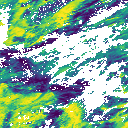
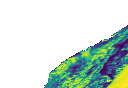
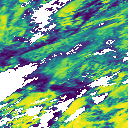
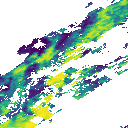
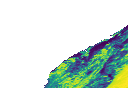

In [26]:
df.select('Name', 'LSTD', rf_crs('LSTD'), rf_extent('LSTD'), 
          'datetime', 'start_date', 'extinguish_date')

Take a look at an individual _Tile_ object.

In [27]:
tile = df.select('LSTD').first()[0]
tile

Row(tile_context=None, tile=Tile(masked_array(
  data=[[15025, 15039, 15043, ..., 14586, 14523, 14505],
        [15046, 15049, 15052, ..., 14538, 14515, 14509],
        [15036, 15049, 15066, ..., --, --, --],
        ...,
        [15080, 15064, 15072, ..., 15257, 15286, 15216],
        [15121, 15115, 15059, ..., 15253, 15195, 15155],
        [15107, 15057, 15095, ..., 15189, 15145, 15145]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=0,
  dtype=uint16), uint16))

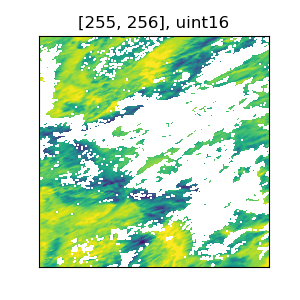

In [28]:
tile.tile

## Get the temperature in Kelvin

Recall 20°C = 293.15K ~= 68°F and 40°C = 313.15K ~= 104°F

We need to multiply each Tile cellwise by 0.02, according to the MOD11A1 documentation.


In [29]:
df = df.withColumn('LST_K',
                   rf_local_multiply('LSTD', 0.02)
)

## Aggregate across satellite images per fire

For each fire, get the maximum temperature from all images.

Since the resulting data is small, maximum of 611 records, we use `toPandas` to bring the Spark DataFrame back to the driver and convert to pandas.

In [30]:
fire_dataset_cols = ['UniqueId', 'Name', 'Started', 'Extinguished', 
                     'Engines', 'Dozers', 'Helicopters',
                     'Fatalities', 'Injuries', 'StructuresDestroyed', 'StructuresDamaged',]

summary = df.groupby(fire_dataset_cols) \
            .agg(rf_agg_stats('LST_K').alias('s')) \
            .select(
                'UniqueId', 'Name',
                F.col('s').max.alias('max_temp_K'),
                *fire_dataset_cols[2:],
                # Other stats from satellite readings
                F.col('s').data_cells.alias('n_pixels'),
                F.col('s').no_data_cells.alias('nodata'),
                F.col('s').mean.alias('mean_temp_K'),
                F.col('s').min.alias('min_temp_K')
        
           ).toPandas()

In [31]:
summary.sort_values('max_temp_K', ascending=False)

,UniqueId,Name,max_temp_K,Started,Extinguished,Engines,Dozers,Helicopters,Fatalities,Injuries,StructuresDestroyed,StructuresDamaged,n_pixels,nodata,mean_temp_K,min_temp_K
54,38d46a2f-d1f6-4ed8-a502-e57e393844ea,South Fire,345.94,2019-09-05T19:59:46Z,2019-12-02T16:12:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,779273,3365879,292.163108,268.98
12,791059a2-b50f-4ab0-924a-bfdac001e4b9,Henthorne Fire,345.94,2019-09-05T09:25:00Z,2019-09-18T12:17:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104354,526430,297.131436,281.54
28,b4616173-5807-4c04-a416-5374139f3fcc,66 Fire,344.90,2019-05-29T21:06:00Z,2019-06-24T11:46:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,846236,202340,320.797608,289.58
37,77671ac0-0868-4cc9-a699-26f0131cd493,Pauma Fire,343.74,2019-06-10T14:25:00Z,2019-06-24T11:44:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,447620,142204,321.765022,289.58
77,72cb3684-c194-4180-bdfe-22775f86a594,Hill Fire,343.44,2019-05-29T17:18:00Z,2019-06-05T15:07:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,260085,67595,309.332237,263.36
4,2ce810c9-88f1-4efe-9254-8cbd339d2397,Long Valley Fire,340.40,2019-08-24T17:25:04Z,2019-08-27T09:01:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128935,2137,313.808252,292.42
78,6311a921-f8e9-45c1-b10d-fee8be8dae29,Lincoln Fire,340.16,2019-07-12T17:15:31Z,2019-07-17T10:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91475,39597,325.262107,300.18
66,f2629bc3-1c8c-4a97-95fa-7d08566dc246,Madera Fire,339.74,2019-07-15T18:19:31Z,2019-07-16T06:49:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119615,11457,316.175896,279.06
40,8c46fde6-7a1c-482b-97cc-afff1bc5d27c,Border Fire,339.72,2019-07-12T13:20:39Z,2019-07-15T17:10:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25603,39933,319.275304,293.38
69,f68808fb-a705-4083-a136-1a45c61c7f74,Tenaja,339.72,2019-09-04T16:43:36Z,2019-09-14T19:00:00Z,1.0,1.0,NaN,NaN,3.0,0.0,2.0,210329,51815,318.146262,295.34
